# Analysis of Airplane Crashes and Safety Trends since 1908: 
## Has the Safety of Air Travel Improved over the Years?

This page explores historical data on airplane crashes, to determine whether the safety of air travel has improved over the years. The analysis covers data collection, cleaning, exploratory and in-depth analysis, and visualisations to understand trends and draw insights.

According to PBS (https://www.pbs.org/wgbh/nova/planecrash/risky.html), the annual risk of being killed in a plane crash for the average Americain is about 1 in 11 million. However, as I am not American I've chosen this data-driven topic to explore, with no plane ticket required.

In [30]:
from IPython.display import Image, display, Markdown

image_url = 'https://images.ctfassets.net/bht415zek091/12581-image-1/a7ce113ab29b84f231fb05debfca56e6/12581-image-1.jpeg'
display(Image(url=image_url))

copyright_text = """
**Image Source:** [Link to Image](https://images.ctfassets.net/bht415zek091/12581-image-1/a7ce113ab29b84f231fb05debfca56e6/12581-image-1.jpeg)  
"""
display(Markdown(copyright_text))



**Image Source:** [Link to Image](https://images.ctfassets.net/bht415zek091/12581-image-1/a7ce113ab29b84f231fb05debfca56e6/12581-image-1.jpeg)  


In [126]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np
import plotly.express as px
from IPython.display import Markdown, display
import matplotlib.dates as mdates

In [101]:
# import cleaned csv file
crashes = pd.read_csv('cleaned_crashes.csv')

In [129]:
# convert 'Date' to datetime format
crashes['Date'] = pd.to_datetime(crashes['Date'])

# add a new column for just the year
crashes['Year'] = crashes['Date'].dt.year

In [34]:
# set sns style
sns.set_style("whitegrid")

## Setting the Scene with a Historical Overview

Let's begin by first understanding the scope we are considering here, just exactly how many airplane crashes and fatalities due to crashes have there been since 1908?

In [125]:
total_crashes = len(crashes)
total_fatalities = int(crashes['Fatalities'].sum())
nan_countries = (crashes['Country'] == 'Unknown').sum()

text = """
Firstly, a little bit about the data itself. This data comes from <a href="https://www.kaggle.com/datasets/saurograndi/airplane-crashes-since-1908">Kaggle.com</a> and covers airplane crashes since 1908. 
This data set has information on {} plane crashes and {} resulting fatalities. During my pre-processing, a new column was added to denote the country 
every airline was from, however for many particularly niche and now defunct small aircraft companies it was not possible 
to locate the country of origin. There are {} missing values, which is something worth improving on if I had more time to provide 
a fully comprehensive analysis. For this investigation nevertheless, these missing values do not have a detrimental 
impact on the conclusions drawn.
""".format(total_crashes, total_fatalities, nan_countries)

display(Markdown('<div style = "font-size: 15px;">{}</div>'.format(text)))

<div style = "font-size: 15px;">
Firstly, a little bit about the data itself. This data comes from <a href="https://www.kaggle.com/datasets/saurograndi/airplane-crashes-since-1908">Kaggle.com</a> and covers airplane crashes since 1908. 
This data set has information on 5268 plane crashes and 105479 resulting fatalities. During my pre-processing, a new column was added to denote the country 
every airline was from, however for many particularly niche and now defunct small aircraft companies it was not possible 
to locate the country of origin. There are 50 missing values, which is something worth improving on if I had more time to provide 
a fully comprehensive analysis. For this investigation nevertheless, these missing values do not have a detrimental 
impact on the conclusions drawn.
</div>

#### Number of Airplane Crashes per Year

In [85]:
# calculate total number of crashes per year
crashes_per_year = crashes.groupby('Year').size().reset_index()
crashes_per_year.columns = ['Year', 'Number of Crashes']

# plot number of airplane crashes per year
fig_crashes = px.line(crashes_per_year, 
              x = 'Year', 
              y = 'Number of Crashes', 
              title = 'Number of Airplane Crashes per Year',
              markers = True,
              labels = {'Number of Crashes': 'Number of Crashes', 'Year': 'Year'})

# set template
fig_crashes.update_layout(template = "plotly_white")

# customise
fig_crashes.update_traces(line = dict(width = 3, color = 'dodgerblue'), 
                  marker = dict(size = 7, color = 'lightskyblue', line = dict(width = 1, color = 'slategrey')))

fig_crashes.update_layout(title = {'text': "Number of Airplane Crashes Per Year", 'y': 0.9, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'},
                  title_font = dict(size = 24, color = 'slategrey'))

fig_crashes.update_xaxes(title_font = dict(size = 18, color='slategrey'), tickfont = dict(family = 'Rockwell', color = 'steelblue', size = 12))
fig_crashes.update_yaxes(title_font = dict(size = 18, color='slategrey'), tickfont = dict(family = 'Rockwell', color = 'steelblue', size = 12))

fig_crashes.update_layout(autosize = False, width = 900, height = 600)

fig_crashes.show()

# fig.write_html('path/to/file.html')  # Save the plot as an HTML file


Without any contextual knowledge, if one just observed this plot it would be valid to suggest that the safety of aircrafts has decreased over time as crashes have become much more common since 1908. There are a few patterns which can be observed here. The first plane was flown in 1903 (https://airandspace.si.edu/collection-objects/1903-wright-flyer/nasm_A19610048000), and especially since the end of World War II, commercial airliners have soared in popularity (https://airandspace.si.edu/explore/stories/commercial-aviation-mid-century#:~:text=After%20World%20War%20II%2C%20passenger,began%20to%20revolutionize%20civil%20aviation). With increasing number of flights, the number of airplane crashes can also reasonably be expected to increase - this does not necessarily mean that flights have become less safe. The peak seen around 1945 is likely a result of WWII, but we can split the number of crashes by operator type (either military or commerical) to further observe these trends.

#### Number of Airplane Crashes per Year by Operator Type

In [86]:
# categorise the crashes
crashes['Type'] = crashes['Operator'].apply(lambda x: 'Military' if 'Military' in str(x) else 'Commercial')

# group by 'Year' and 'Type' and count number of crashes
crashes_per_year_type = crashes.groupby(['Year', 'Type']).size().reset_index(name = 'Number of Crashes')

# plot number of airplane craashes per year separating military and commercial flights
fig_operator = px.line(crashes_per_year_type, 
              x = 'Year', 
              y = 'Number of Crashes', 
              color = 'Type',  
              title = 'Number of Airplane Crashes per Year by Operator Type',
              markers = True,  
              labels = {'Number of Crashes': 'Number of Crashes', 'Year': 'Year', 'Type': 'Operator Type'})

# set template
fig_operator.update_layout(template = "plotly_white")

# customise
fig_operator.update_traces(line = dict(width = 3), 
                  marker=dict(size = 7, line=dict(width = 1)))

fig_operator.update_layout(
    title = {'text': "Number of Airplane Crashes per Year by Operator Type", 'y': 0.9, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'},
    title_font = dict(size = 24, color = 'slategrey'),
    xaxis_title_font = dict(size = 18, color = 'slategrey'),
    yaxis_title_font = dict(size = 18, color = 'slategrey'),
    xaxis = dict(tickfont = dict(family = 'Rockwell', color = 'steelblue', size = 12)),
    yaxis = dict(tickfont = dict(family = 'Rockwell', color = 'steelblue', size = 12)),
    legend_title_font = dict(size = 18, color = 'slategrey'),
    legend = dict(font = dict(size = 12, color = 'slategrey'))
)

fig_operator.update_layout(autosize = False, width = 900, height = 600)

colors = {'Military': 'cadetblue', 'Commercial': 'mediumslateblue'}  
fig_operator.for_each_trace(lambda t: t.update(line = dict(color = colors[t.name]), 
                                      marker = dict(color = colors[t.name])))

fig_operator.show()

# fig.write_html('path/to/second_plot.html')


The above visualisation distinguishes the number of airplane crashes by the type of operator, either military or commercial flights. Both types show significant variability over the years, with different periods of peaks and troughs. Military crashes were very few in numbers in the early years, with a slight peak during World War I (1914-1918), staying low until World War II (1939-1945). 1945 is the only year on record where the number of military crashes exceeded commerical crashes. Commerical crashes have seen a large increase since 1908, but appear to be declining as we move into the 21st century, which could possibly reflect increased safety measures being successfully implemented. 

Let's now briefly inspect the number of fatalities caused by airplane crashes per year. 

#### Number of Fatalities per Year by Operator Type

In [89]:
# group data by 'Year' and 'Type' and count number of fatalities
fatalities_per_year_type = crashes.groupby(['Year', 'Type'])['Fatalities'].sum().reset_index(name = 'Number of Fatalities')

# plot numer of fatalities per year by operator type
fig_fatalities = px.line(fatalities_per_year_type, 
                         x = 'Year', 
                         y = 'Number of Fatalities', 
                         color = 'Type', 
                         title = 'Number of Airplane Fatalities per Year by Operator Type',
                         markers = True,
                         labels = {'Number of Fatalities': 'Number of Fatalities', 'Year': 'Year', 'Type': 'Operator Type'})


# set template
fig_fatalities.update_layout(template = "plotly_white")

# customise
fig_fatalities.update_traces(line = dict(width = 3), 
                             marker = dict(size = 7, line = dict(width = 1)))

fig_fatalities.update_layout(
    title = {'text': "Number of Airplane Fatalities per Year by Operator Type", 'y': 0.9, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'},
    title_font = dict(size = 24, color = 'slategrey'),
    xaxis_title_font = dict(size = 18, color = 'slategrey'),
    yaxis_title_font = dict(size = 18, color = 'slategrey'),
    xaxis = dict(tickfont = dict(family = 'Rockwell', color = 'steelblue', size = 12)),
    yaxis = dict(tickfont = dict(family = 'Rockwell', color = 'steelblue', size = 12)),
    legend_title_font = dict(size = 18, color = 'slategrey'),
    legend = dict(font = dict(size = 12, color = 'slategrey'))
)

colors = {'Military': 'cadetblue', 'Commercial': 'mediumslateblue'}  
fig_fatalities.for_each_trace(lambda t: t.update(line = dict(color = colors[t.name]), 
                                                 marker = dict(color = colors[t.name])))

fig_fatalities.update_layout(autosize = False, width = 900, height =  600)

fig_fatalities.show()

# fig_fatalities.write_html('path/to/fatalities_plot.html')


Here, we see a similar pattern to the number of airplane crashes plot - incidcating, as one might expect, that the higher the airplane crashes the higher the airplane crash fatalities. The spikes exhibited around the 1980s suggest one or a few extremely deadly airplane crashes may have occured, and the subsequent drop in fatalities may be a result of improvements in aviation safety.

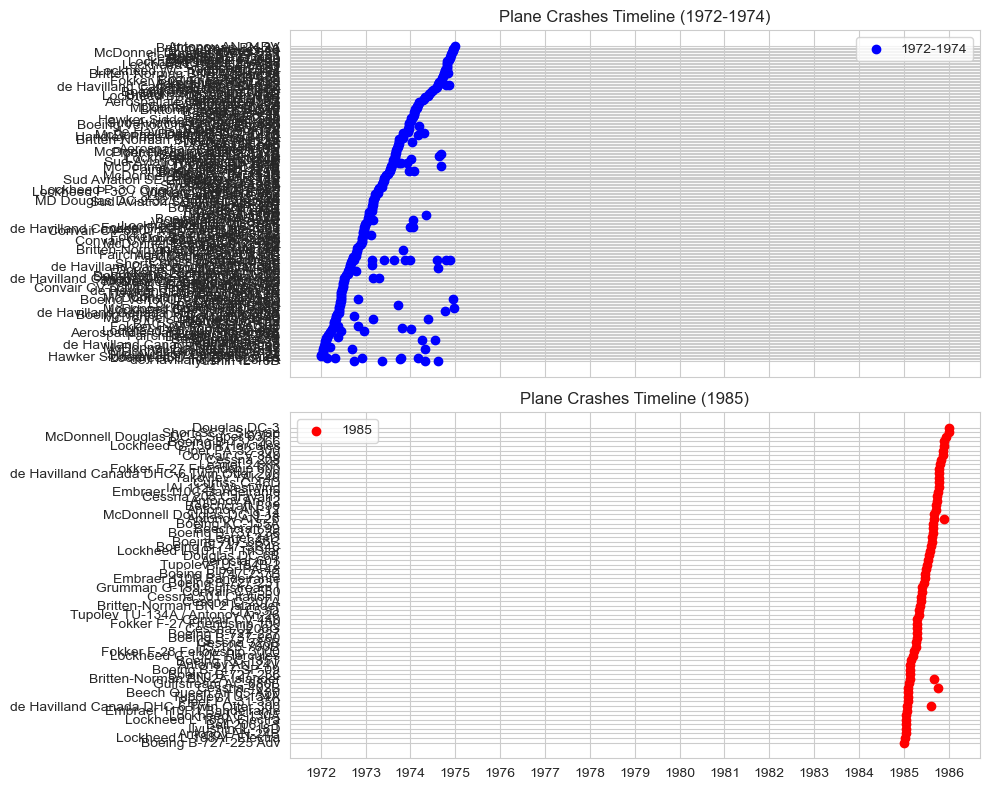

In [131]:
timeframe_data = crashes[(crashes['Date'].dt.year >= 1972) & (crashes['Date'].dt.year <= 1974)]
year_1985_data = crashes[crashes['Date'].dt.year == 1985]

# Create the plot
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax[0].scatter(timeframe_data['Date'], timeframe_data['Type'], color='blue', label='1972-1974')
ax[0].set_title('Plane Crashes Timeline (1972-1974)')
ax[0].xaxis.set_major_locator(mdates.YearLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax[0].grid(True)
ax[0].legend()

ax[1].scatter(year_1985_data['Date'], year_1985_data['Type'], color='red', label='1985')
ax[1].set_title('Plane Crashes Timeline (1985)')
ax[1].xaxis.set_major_locator(mdates.YearLocator())
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()

# A Comparative Analysis of Airplane Crashes by Country

Now, to delve into whether 

In [17]:
# Identify the top 5 countries with the highest total number of crashes

top_countries = crashes['Country'].value_counts().nlargest(1).index

# Filter the crashes DataFrame to include only the top 5 countries

# First, create a copy of the filtered DataFrame to avoid modifying the original one
top_crashes = crashes[crashes['Country'].isin(top_countries)].copy()

# Then use `.loc` to set values in the 'Type' column
top_crashes.loc[:, 'Type'] = top_crashes['Operator'].apply(lambda x: 'Military' if 'Military' in x else 'Commercial')


# Categorize each crash

# Group by 'Year', 'Country' and 'Type' and count the number of crashes
crashes_per_year_country_type = top_crashes.groupby(['Year', 'Country', 'Type']).size().reset_index(name='Number of Crashes')

# Create an interactive plot using Plotly Express
fig = px.line(crashes_per_year_country_type, 
              x='Year', 
              y='Number of Crashes', 
              color='Country',  # Differentiate lines by 'Country'
              line_dash='Type',  # Differentiate lines by 'Type' using different dash styles
              title='Number of Airplane Crashes Per Year by Country and Type',
              markers=True,  # To add markers to the lines
              labels={'Number of Crashes': 'Number of Crashes', 'Year': 'Year', 'Type': 'Operator Type'})

# Show the figure
fig.show()

In [19]:
crashes_filtered = crashes[crashes['Country'] != 'United States'].copy()

# Categorize each crash in the filtered data
crashes_filtered['Type'] = crashes_filtered['Operator'].apply(lambda x: 'Military' if 'Military' in str(x) else 'Commercial')

# Group by 'Year' and 'Type' and count the number of crashes in the filtered data
crashes_per_year_type_filtered = crashes_filtered.groupby(['Year', 'Type']).size().reset_index(name='Number of Crashes')

# Create an interactive plot using Plotly Express with color distinction
fig = px.line(crashes_per_year_type_filtered, 
              x='Year', 
              y='Number of Crashes', 
              color='Type',  # Differentiate lines by 'Type'
              title='Number of Airplane Crashes Per Year by Type (Excluding United States)',
              markers=True,  # To add markers as in the original plot
              labels={'Number of Crashes': 'Number of Crashes', 'Year': 'Year', 'Type': 'Operator Type'})

# Show the figure
fig.show()

In [24]:
import plotly.express as px

# Group data by 'Year' and 'Type' and count the number of crashes
crashes_per_year_type = crashes.groupby(['Year', 'Type'])['Flight #'].count().reset_index(name='Number of Crashes')

# Group data by 'Year' and 'Type' and sum the fatalities
fatalities_per_year_type = crashes.groupby(['Year', 'Type'])['Fatalities'].sum().reset_index(name='Number of Fatalities')

# Create the first plot for the number of crashes
fig_crashes = px.line(crashes_per_year_type, 
                      x='Year', 
                      y='Number of Crashes', 
                      color='Type', 
                      title='Number of Airplane Crashes Per Year by Type',
                      markers=True,
                      labels={'Number of Crashes': 'Number of Crashes', 'Year': 'Year', 'Type': 'Operator Type'})

# Create the second plot for the number of fatalities
fig_fatalities = px.line(fatalities_per_year_type, 
                         x='Year', 
                         y='Number of Fatalities', 
                         color='Type', 
                         title='Number of Airplane Fatalities Per Year by Type',
                         markers=True,
                         labels={'Number of Fatalities': 'Number of Fatalities', 'Year': 'Year', 'Type': 'Operator Type'})

# Show the figures
fig_crashes.show()
fig_fatalities.show()

# If you need to embed these in a web page, you can save each figure as an HTML file
# fig_crashes.write_html('path/to/crashes_plot.html')
# fig_fatalities.write_html('path/to/fatalities_plot.html')


In [21]:
# Group by 'Year', 'Country', 'Type' and count the number of crashes and sum fatalities
yearly_data = crashes.groupby(['Year', 'Country', 'Type']).agg({'Flight #': 'size', 'Fatalities': 'sum'}).reset_index()
yearly_data.rename(columns={'Flight #': 'Number of Crashes'}, inplace=True)

# Create the choropleth map
fig = px.choropleth(yearly_data,
                     locations="Country", 
                     locationmode="country names",
                     color="Number of Crashes",
                     hover_name="Country", 
                     hover_data={"Type": True, "Fatalities": True},
                     animation_frame="Year", 
                     range_color=[0, yearly_data['Number of Crashes'].max()],
                     title="Crashes and Fatalities per Year",
                     labels={'Number of Crashes': 'Number of Crashes', 'Fatalities': 'Fatalities', 'Type': 'Operator Type'})

# Update the layout for a cleaner look
fig.update_layout(geo=dict(showcoastlines=True, coastlinecolor="RebeccaPurple"))

# Show the figure
fig.show()

In [5]:
import plotly.express as px
crashes_count = crashes.groupby('ISO_Code').size().reset_index(name='counts')


fig = px.choropleth(crashes_count, 
                    locations="ISO_Code",
                    color="counts",
                    hover_name="ISO_Code",
                    color_continuous_scale=px.colors.sequential.Viridis,
                    title='Number of Plane Crashes per Country')

fig.update_layout(geo=dict(showframe=False, showcoastlines=False))
fig.show()


In [83]:
fig = px.choropleth(crashes_count, 
                    locations="ISO_Code",
                    color="counts",
                    hover_name="ISO_Code",
                    color_continuous_scale=px.colors.sequential.Plasma,  # A different color scale for better contrast
                    title='Number of Plane Crashes per Country')

fig.update_layout(
    geo=dict(
        showframe=True, 
        showcoastlines=True, 
        projection_type='natural earth'  # More realistic projection type
    ),
    title=dict(
        x=0.5,  # Center title
        xanchor='center'
    ),
    coloraxis_colorbar=dict(
        title='Total Crashes'  # More descriptive title for the color bar
    )
)

# Optionally, make the figure full-width in the notebook for better visibility
fig.update_layout(width=1200, height=600)  # Adjust the size as needed

fig.show()
